In [1]:
from keras.models import Sequential
from keras.layers import Dense, Activation,Dropout

import ROOT as rt
import uproot
#from root_numpy import root2array, tree2array
#from root_pandas import read_root
import h5py 

from sklearn.preprocessing import LabelEncoder
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import keras.backend as K
from keras.metrics import SparseCategoricalAccuracy
from keras.losses import SparseCategoricalCrossentropy

from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args

from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

import numpy as np
import numpy.lib.recfunctions as nlr
import pandas as pd
import os, sys
from matplotlib import pyplot as plt
import math
try:
    import setGPU
except:
    os.environ['KERAS_BACKEND'] = 'tensorflow'
    os.environ['CUDA_VISIBLE_DEVICES'] = '5'

import gpustat
gpustat.print_gpustat()
os.environ['CUDA_VISIBLE_DEVICES']='3'

Welcome to JupyROOT 6.22/02
setGPU: Setting GPU to: 0
gpu-ibanks-2.hep.caltech.edu  Thu Aug 26 20:03:16 2021  470.57.02
[0] NVIDIA TITAN Xp  | 28'C,   0 % |     1 / 12196 MB |
[1] NVIDIA TITAN Xp  | 27'C,   0 % |     1 / 12196 MB |
[2] NVIDIA TITAN Xp  | 29'C,   0 % |     1 / 12196 MB |
[3] NVIDIA TITAN Xp  | 24'C,   0 % |     1 / 12196 MB |
[4] NVIDIA TITAN Xp  | 25'C,   0 % |     1 / 12196 MB |
[5] NVIDIA TITAN Xp  | 23'C,   0 % |     1 / 12196 MB |


### Load MC samples

In [2]:
def samp_to_df(samp_name, total_num):
    dfs = []
    tree_vars = [b'leading_photon_pt', b'subleading_photon_pt', b'diphoton_pt', b'diphoton_mass',
           b'leading_bjet_pt', b'subleading_bjet_pt', b'dibjet_pt', b'dibjet_mass',
           b'leading_bjet_pt_corr', b'subleading_bjet_pt_corr', b'dibjet_pt_corr', b'dibjet_mass_corr',
           b'leading_pho_pt_over_dimass', b'leading_bjet_pt_over_dimass', b'leading_bjet_pt_over_dimass_corr',
           b'subleading_pho_pt_over_dimass', b'subleading_bjet_pt_over_dimass', b'subleading_bjet_pt_over_dimass_corr',
           b'leading_photon_phi', b'leading_photon_eta', b'subleading_photon_phi', b'subleading_photon_eta',
           b'diphoton_eta', b'photon_delR', b'diphoton_pt_over_diphoton_mass',
           b'leading_bjet_phi', b'leading_bjet_eta', b'subleading_bjet_phi', b'subleading_bjet_eta',
           b'dibjet_eta', b'bjet_delR', b'dibjet_pt_over_dibjet_mass', b'dibjet_pt_over_dibjet_mass_corr',
           b'leadingDeepBscore', b'subleadingDeepBscore', b'sumDeepBscore',
           b'rec_pho_bjet_min_dR', b'all_pho_bjet_min_dR', b'dphi_met_leading_bjet', b'dphi_met_subleading_bjet',
           b'leading_vbfjet_pt', b'subleading_vbfjet_pt', b'divbfjet_pt', b'divbfjet_mass',
           b'leading_vbfjet_phi', b'leading_vbfjet_eta', b'subleading_vbfjet_phi', b'subleading_vbfjet_eta',
           b'leading_vbfjet_pt_over_dimass', b'subleading_vbfjet_pt_over_dimass', b'divbfjet_pt_over_dimass',
           b'divbfjet_eta', b'vbfjet_delR', b'vbfjet_del_eta',
           b'MET_pt', b'MET_phi', b'MET_sumEt',
           b'recon', b'ggHH_recon', b'VBFHH_recon', b'genweight', b'nbjet', b'nvbfjet', b'nphoton', b'njet',
           b'run', b'lumi', b'event']
    for i in range(total_num+1):
        file_name = f'/storage/af/user/schen7/CMSSW_9_4_2/src/Higgs/HHbbgg/HHbbggAna/condor/output/{samp_name}{i}.root'
        samp_file = uproot.open(file_name)
        samp_array = samp_file['tree'].arrays(tree_vars)
        samp_df = pd.DataFrame(samp_array)
        dfs.append(samp_df)
    combine_df = pd.concat(dfs)
    return combine_df

In [3]:
# Set up dataframes - 2018 

# Signals
GluGluToHH_df_2018 = samp_to_df('job_2_ntuple20180819v1/GluGluToHHTo2B2G_node_cHHH1_TuneCP5_PSWeights_13TeV-powheg-pythia8Job2ifile', 0)
VBFHH_df_2018= samp_to_df('job_3_ntuple20180819v1/VBFHHTo2B2G_CV_1_C2V_1_C3_1_TuneCP5_PSWeights_13TeV-madgraph-pythia8Job3ifile', 0)

# Backgrounds
VHToGG_df_2018 = samp_to_df('job_4_ntuple20180819v1/VHToGG_M125_13TeV_amcatnloFXFX_madspin_pythia8Job4ifile', 0)
ttHToGG_df_2018 = samp_to_df('job_5_ntuple20180819v1/ttHToGG_M125_TuneCP5_PSweights_13TeV-powheg-pythia8Job5ifile', 0)
VBFHToGG_df_2018 = samp_to_df('job_6_ntuple20180819v1/VBFHToGG_M125_13TeV_amcatnlo_pythia8Job6ifile', 0)
GluGluHToGG_df_2018 = samp_to_df('job_7_ntuple20180819v1/GluGluHToGG_M125_TuneCP5_13TeV-amcatnloFXFX-pythia8Job7ifile', 0)
TTJets_df_2018 = samp_to_df('job_8_ntuple20180819v1/TTJets_TuneCP5_13TeV-amcatnloFXFX-pythia8Job8ifile', 60)
TTGJets_df_2018 = samp_to_df('job_9_ntuple20180819v1/TTGJets_TuneCP5_13TeV-amcatnloFXFX-madspin-pythia8Job9ifile', 3)
TTGG_0Jets_df_2018 = samp_to_df('job_10_ntuple20180819v1/TTGG_0Jets_TuneCP5_13TeV_amcatnlo_madspin_pythia8Job10ifile', 5)
GJet_SmallPt_df_2018 = samp_to_df('job_11_ntuple20180819v1/GJet_Pt-20to40_DoubleEMEnriched_MGG-80toInf_TuneCP5_13TeV_Pythia8Job11ifile', 3)
GJet_BigPt_df_2018 = samp_to_df('job_12_ntuple20180819v1/GJet_Pt-40toInf_DoubleEMEnriched_MGG-80toInf_TuneCP5_13TeV_Pythia8Job12ifile', 2)
DiPhotonJetsBox_df_2018 = samp_to_df('job_13_ntuple20180819v1/DiPhotonJetsBox_MGG-80toInf_13TeV-SherpaJob13ifile', 4)
DiPhotonJetsBox1B_df_2018 = samp_to_df('job_14_ntuple20180819v1/DiPhotonJetsBox1BJet_MGG-80toInf_13TeV-SherpaJob14ifile', 0)
DiPhotonJetsBox2B_df_2018 = samp_to_df('job_15_ntuple20180819v1/DiPhotonJetsBox2BJets_MGG-80toInf_13TeV-SherpaJob15ifile', 0)
QCD_Jets_df_2018 = samp_to_df('job_16_ntuple20180819v1/QCD_Pt-40toInf_DoubleEMEnriched_MGG-80toInf_TuneCP5_13TeV_Pythia8Job16ifile', 15)

# Set up dataframes - 2017

# Signals
GluGluToHH_df_2017 = samp_to_df('job_2_ntuple20170819v1/GluGluToHHTo2B2G_node_cHHH1_TuneCP5_PSWeights_13TeV-powheg-pythia8Job2ifile', 3)
VBFHH_df_2017 = samp_to_df('job_3_ntuple20170819v1/VBFHHTo2B2G_CV_1_C2V_1_C3_1_13TeV-madgraphJob3ifile', 1)

# Backgrounds
VHToGG_df_2017 = samp_to_df('job_4_ntuple20170819v1/VHToGG_M125_13TeV_amcatnloFXFX_madspin_pythia8Job4ifile', 0)
ttHToGG_df_2017 = samp_to_df('job_5_ntuple20170819v1/ttHToGG_M125_13TeV_powheg_pythia8Job5ifile', 0)
VBFHToGG_df_2017 = samp_to_df('job_6_ntuple20170819v1/VBFHToGG_M-125_13TeV_powheg_pythia8Job6ifile', 2)
GluGluHToGG_df_2017 = samp_to_df('job_7_ntuple20170819v1/GluGluHToGG_M-125_13TeV_powheg_pythia8Job7ifile', 0)
TTJets_df_2017 = samp_to_df('job_8_ntuple20170819v1/TTJets_TuneCP5_13TeV-amcatnloFXFX-pythia8Job8ifile', 38)
TTGJets_df_2017 = samp_to_df('job_9_ntuple20170819v1/TTGJets_TuneCP5_13TeV-amcatnloFXFX-madspin-pythia8Job9ifile', 10)
TTGG_0Jets_df_2017 = samp_to_df('job_10_ntuple20170819v1/TTGG_0Jets_TuneCP5_13TeV_amcatnlo_madspin_pythia8Job10ifile', 1)
GJet_SmallPt_df_2017 = samp_to_df('job_11_ntuple20170819v1/GJet_Pt-20to40_DoubleEMEnriched_MGG-80toInf_TuneCP5_13TeV_Pythia8Job11ifile', 2)
GJet_BigPt_df_2017 = samp_to_df('job_12_ntuple20170819v1/GJet_Pt-40toInf_DoubleEMEnriched_MGG-80toInf_TuneCP5_13TeV_Pythia8Job12ifile', 20)
DiPhotonJetsBox_df_2017 = samp_to_df('job_1_ntuple20170819v2/DiPhotonJetsBox_MGG-80toInf_13TeV-SherpaJob1ifile', 16)
DiPhotonJetsBox1B_df_2017 = samp_to_df('job_14_ntuple20170819v1/DiPhotonJetsBox1BJet_MGG-80toInf_13TeV-SherpaJob14ifile', 3)
DiPhotonJetsBox2B_df_2017 = samp_to_df('job_15_ntuple20170819v1/DiPhotonJetsBox2BJets_MGG-80toInf_13TeV-SherpaJob15ifile', 5)
QCD_Jets_df_2017 = samp_to_df('job_16_ntuple20170819v1/QCD_Pt-40toInf_DoubleEMEnriched_MGG-80toInf_TuneCP5_13TeV_Pythia8Job16ifile', 3)

# Set up dataframes - 2016 

# Signals
GluGluToHH_df_2016 = samp_to_df('job_2_ntuple20160819v1/GluGluToHHTo2B2G_node_cHHH1_TuneCUETP8M1_PSWeights_13TeV-powheg-pythia8Job2ifile', 0)
VBFHH_df_2016 = samp_to_df('job_3_ntuple20160819v1/VBFHHTo2B2G_CV_1_C2V_1_C3_1_13TeV-madgraphJob3ifile', 0)

# Background
VHToGG_df_2016 = samp_to_df('job_4_ntuple20160819v1/VHToGG_M125_13TeV_amcatnloFXFX_madspin_pythia8Job4ifile', 0)
ttHToGG_df_2016 = samp_to_df('job_5_ntuple20160819v1/ttHToGG_M125_13TeV_powheg_pythia8_v2Job5ifile', 0)
VBFHToGG_df_2016 = samp_to_df('job_6_ntuple20160819v1/VBFHToGG_M125_13TeV_amcatnlo_pythia8_v2Job6ifile', 2)
GluGluHToGG_df_2016 = samp_to_df('job_7_ntuple20160819v1/GluGluHToGG_M125_13TeV_amcatnloFXFX_pythiaJob7ifile', 0)
TTJets_df_2016 = samp_to_df('job_8_ntuple20160819v1/TTJets_TuneCUETP8M2T4_13TeV-amcatnloFXFX-pythia8Job8ifile', 8)
TTGJets_df_2016 = samp_to_df('job_9_ntuple20160819v1/TTGJets_TuneCUETP8M1_13TeV-amcatnloFXFX-madspin-pythia8Job9ifile', 2)
TTGG_0Jets_df_2016 = samp_to_df('job_10_ntuple20160819v1/TTGG_0Jets_TuneCUETP8M1_13TeV_amcatnlo_madspin_pythia8Job10ifile', 0)
GJet_SmallPt_df_2016 = samp_to_df('job_11_ntuple20160819v1/GJet_Pt-20to40_DoubleEMEnriched_MGG-80toInf_TuneCUETP8M1_13TeV_Pythia8Job11ifile', 2)
GJet_BigPt_df_2016 = samp_to_df('job_12_ntuple20160819v1/GJet_Pt-40toInf_DoubleEMEnriched_MGG-80toInf_TuneCUETP8M1_13TeV_Pythia8Job12ifile', 12)
DiPhotonJetsBox_df_2016 = samp_to_df('job_13_ntuple20160819v1/DiPhotonJetsBox_MGG-80toInf_13TeV-SherpaJob13ifile', 9)
DiPhotonJetsBox1B_df_2016 = samp_to_df('job_14_ntuple20160819v1/DiPhotonJetsBox1BJet_MGG-80toInf_TuneSherpa_13TeV-SherpaJob14ifile', 3)
DiPhotonJetsBox2B_df_2016 = samp_to_df('job_15_ntuple20160819v1/DiPhotonJetsBox2BJets_MGG-80toInf_TuneSherpa_13TeV-SherpaJob15ifile', 4)
QCD_Jets_df_2016 = samp_to_df('job_16_ntuple20160819v1/QCD_Pt-40toInf_DoubleEMEnriched_MGG-80toInf_TuneCUETP8M1_13TeV_Pythia8Job16ifile', 3)

# Combine by sample (recon == 1; photon cut == 90)

# Signals 
GluGluToHH_df = pd.concat([GluGluToHH_df_2018, GluGluToHH_df_2017, GluGluToHH_df_2016], ignore_index=True)
VBFHH_df = pd.concat([VBFHH_df_2018, VBFHH_df_2017, VBFHH_df_2016], ignore_index=True)

# Backgrounds
VHToGG_df = pd.concat([VHToGG_df_2018, VHToGG_df_2017, VHToGG_df_2016], ignore_index=True)
ttHToGG_df = pd.concat([ttHToGG_df_2018, ttHToGG_df_2017, ttHToGG_df_2016], ignore_index=True)
VBFHToGG_df = pd.concat([VBFHToGG_df_2018, VBFHToGG_df_2017, VBFHToGG_df_2016], ignore_index=True)
GluGluHToGG_df = pd.concat([GluGluHToGG_df_2018, GluGluHToGG_df_2017, GluGluHToGG_df_2016], ignore_index=True)
TTJets_df= pd.concat([TTJets_df_2018, TTJets_df_2017, TTJets_df_2016], ignore_index=True)
TTGJets_df = pd.concat([TTGJets_df_2018, TTGJets_df_2017, TTGJets_df_2016], ignore_index=True)
TTGG_0Jets_df = pd.concat([TTGG_0Jets_df_2018, TTGG_0Jets_df_2017, TTGG_0Jets_df_2016], ignore_index=True)
GJet_SmallPt_df = pd.concat([GJet_SmallPt_df_2018, GJet_SmallPt_df_2017, GJet_SmallPt_df_2016], ignore_index=True)
GJet_BigPt_df = pd.concat([GJet_BigPt_df_2018, GJet_BigPt_df_2017, GJet_BigPt_df_2016], ignore_index=True)
DiPhotonJetsBox_df = pd.concat([DiPhotonJetsBox_df_2018, DiPhotonJetsBox_df_2017, DiPhotonJetsBox_df_2016], ignore_index=True)
DiPhotonJetsBox1B_df = pd.concat([DiPhotonJetsBox1B_df_2018, DiPhotonJetsBox1B_df_2017, DiPhotonJetsBox1B_df_2016], ignore_index=True)
DiPhotonJetsBox2B_df = pd.concat([DiPhotonJetsBox2B_df_2018, DiPhotonJetsBox2B_df_2017, DiPhotonJetsBox2B_df_2016], ignore_index=True)
QCD_Jets_df = pd.concat([QCD_Jets_df_2018, QCD_Jets_df_2017, QCD_Jets_df_2016], ignore_index=True)

In [4]:
# Select ggHH signal specifically -- pho == 90

dfs_combine = [GluGluToHH_df, VBFHH_df,
               VHToGG_df, ttHToGG_df, VBFHToGG_df, GluGluHToGG_df, 
                TTJets_df, TTGJets_df, TTGG_0Jets_df, 
            GJet_SmallPt_df, GJet_BigPt_df,
             DiPhotonJetsBox_df, DiPhotonJetsBox1B_df, DiPhotonJetsBox2B_df, QCD_Jets_df]

dfs_ggHH = []

for i in range(len(dfs_combine)):
    df_ggHH = dfs_combine[i][dfs_combine[i][b'ggHH_recon'] == 1]
    dfs_ggHH.append(df_ggHH)

## Preprocessing

In [5]:
mc_labels = ['GluGluToHH', 'VBFToHH',
            'VHToGG', 'ttHToGG', 'VBFHToGG', 'GluGluHtoGG',
            'TTJets', 'TTGJets', 'TTGG_0Jets',
            'GJet_SmallPt', 'GJet_BigPt', 'DiPhotonJetsBox', 'DiPhotonJetsBox1B', 'DiPhotonJetsBox2B', 'QCDJets']

dfs_ggHH_label = []
total = 0
for i in range(len(mc_labels)):
    df = pd.DataFrame()
    for column in list(dfs_ggHH[i].columns):
        df[column] = dfs_ggHH[i].loc[:, column].values
    samp_label = [mc_labels[i]] * len(dfs_ggHH[i].index)
    df[b'label'] = samp_label
    print(mc_labels[i])
    print(len(dfs_ggHH[i].index))
    total += len(dfs_ggHH[i].index)
    samp_label_num = [i] * len(dfs_ggHH[i].index)
    df[b'label_num'] = samp_label_num
    dfs_ggHH_label.append(df)

full_df = pd.concat(dfs_ggHH_label, ignore_index=True)
print(total)
print(len(full_df.index))
print(full_df[b'label'].value_counts())
full_df.head()

GluGluToHH
115095
VBFToHH
123786
VHToGG
150739
ttHToGG
128314
VBFHToGG
117796
GluGluHtoGG
131781
TTJets
233707
TTGJets
80870
TTGG_0Jets
45301
GJet_SmallPt
2565
GJet_BigPt
78388
DiPhotonJetsBox
1970698
DiPhotonJetsBox1B
79813
DiPhotonJetsBox2B
43283
QCDJets
414
3302550
3302550
DiPhotonJetsBox      1970698
TTJets                233707
VHToGG                150739
GluGluHtoGG           131781
ttHToGG               128314
VBFToHH               123786
VBFHToGG              117796
GluGluToHH            115095
TTGJets                80870
DiPhotonJetsBox1B      79813
GJet_BigPt             78388
TTGG_0Jets             45301
DiPhotonJetsBox2B      43283
GJet_SmallPt            2565
QCDJets                  414
Name: b'label', dtype: int64


,b'leading_photon_pt',b'subleading_photon_pt',b'diphoton_pt',b'diphoton_mass',b'leading_bjet_pt',b'subleading_bjet_pt',b'dibjet_pt',b'dibjet_mass',b'leading_bjet_pt_corr',b'subleading_bjet_pt_corr',...,b'genweight',b'nbjet',b'nvbfjet',b'nphoton',b'njet',b'run',b'lumi',b'event',b'label',b'label_num'
0,81.548317,68.587204,84.036278,124.439453,80.1250,60.7500,88.046196,111.977684,89.827637,63.123047,...,-0.000028,3,0,2,6,1,1121,112017,GluGluToHH,0
1,109.037231,87.997322,153.144653,124.160385,115.9375,69.3125,160.948395,111.282120,117.749023,75.133667,...,0.000028,2,0,2,5,1,1121,112010,GluGluToHH,0
2,99.698898,54.716755,92.352104,124.160637,92.5625,26.7500,112.699577,106.316811,100.517090,32.967285,...,0.000028,2,1,2,10,1,1121,112001,GluGluToHH,0
3,78.673645,74.914726,111.698479,120.000145,178.5000,31.0625,172.392776,125.170486,164.816162,27.756042,...,0.000028,2,0,2,13,1,1121,112006,GluGluToHH,0
4,447.419708,159.403656,594.103027,123.621674,485.0000,46.3750,525.561584,98.438232,465.817871,57.153564,...,0.000028,2,0,2,8,1,1121,112019,GluGluToHH,0


In [6]:
# define variables
training_vars = [b'leading_photon_eta', b'leading_photon_phi', 
                b'subleading_photon_eta', b'subleading_photon_phi',
                 b'leading_bjet_pt_corr', b'leading_bjet_eta', b'leading_bjet_phi',
                 b'subleading_bjet_pt_corr', b'subleading_bjet_eta', b'subleading_bjet_phi',
                 b'leadingDeepBscore', b'subleadingDeepBscore', b'sumDeepBscore',
                 b'leading_pho_pt_over_dimass', b'subleading_pho_pt_over_dimass',
                 b'diphoton_pt_over_diphoton_mass', b'dibjet_pt_over_dibjet_mass_corr',
                 b'rec_pho_bjet_min_dR', b'all_pho_bjet_min_dR', b'dphi_met_leading_bjet', b'dphi_met_subleading_bjet',
                 b'MET_pt', b'MET_phi', b'MET_sumEt',
                 b'nbjet', b'nphoton', b'njet'
                ]

aug_vars = [b'dibjet_mass', b'diphoton_mass', b'event']

w_var = [b'genweight']

# select df columns
x_df = full_df[training_vars]
x_full_df = full_df[training_vars + aug_vars + w_var]
y_df = full_df[b'label_num']
X = x_df.values
X_weights = full_df[w_var].values
Y = y_df.values

In [7]:
# split into training and test; following: https://www.kaggle.com/hungdo1291/keras-dnn-multi-class
random_seed=2
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state=random_seed)
X_train_weight, X_val_weight, ph_1, ph_2 = train_test_split(X_weights, Y, test_size = 0.2, random_state=random_seed)

## Model Setup

In [8]:
def multi_DNN(n_hidden = 2, first_neuron = 100, n_neurons = 64, dropout_rate = 0.3, activation_func = 'sigmoid', lr= 0.00002):
    model = Sequential()
    model.add(Dense(first_neuron, input_dim=len(training_vars), activation='relu'))
    model.add(Dropout(dropout_rate))
    for layer in range(n_hidden):
        model.add(Dense(n_neurons, activation = activation_func))
        model.add(Dropout(dropout_rate))
    model.add(Dense(15, activation = 'softmax'))
    opt = Adam(learning_rate = lr)
    model.compile(loss=SparseCategoricalCrossentropy(), optimizer=opt, metrics=[SparseCategoricalAccuracy()])
    return model

## Model Test

In [9]:
model = multi_DNN()
history = model.fit(X_train, Y_train, epochs=200,batch_size=64, validation_split = 0.2, 
            callbacks=[EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')])

Epoch 1/200
33026/33026 [==============================] - 119s 4ms/step - loss: 1.7105 - sparse_categorical_accuracy: 0.5844 - val_loss: 1.6198 - val_sparse_categorical_accuracy: 0.5966
Epoch 2/200
33026/33026 [==============================] - 119s 4ms/step - loss: 1.6392 - sparse_categorical_accuracy: 0.5970 - val_loss: 1.5947 - val_sparse_categorical_accuracy: 0.5966
Epoch 3/200
33026/33026 [==============================] - 120s 4ms/step - loss: 1.6127 - sparse_categorical_accuracy: 0.5982 - val_loss: 1.5541 - val_sparse_categorical_accuracy: 0.6011
Epoch 4/200
33026/33026 [==============================] - 119s 4ms/step - loss: 1.5726 - sparse_categorical_accuracy: 0.6009 - val_loss: 1.5121 - val_sparse_categorical_accuracy: 0.6071
Epoch 5/200
33026/33026 [==============================] - 119s 4ms/step - loss: 1.5381 - sparse_categorical_accuracy: 0.6056 - val_loss: 1.4947 - val_sparse_categorical_accuracy: 0.6161
Epoch 6/200
33026/33026 [==============================] - 119s 4

2021-08-26 20:05:02.330463: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2021-08-26 20:05:02.439279: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:0c:00.0 name: NVIDIA TITAN Xp computeCapability: 6.1
coreClock: 1.582GHz coreCount: 30 deviceMemorySize: 11.91GiB deviceMemoryBandwidth: 510.07GiB/s
2021-08-26 20:05:02.439355: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2021-08-26 20:05:02.678543: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2021-08-26 20:05:02.796354: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10
2021-08-26 20:05:02.915910: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcurand.so.10


In [10]:
evalu = model.evaluate(X_val, Y_val)
metrics = model.metrics_names
print(f"{metrics[1]}: {evalu[1]}")
print(f"{metrics[0]}: {evalu[0]}")

20641/20641 [==============================] - 45s 2ms/step - loss: 1.1207 - sparse_categorical_accuracy: 0.6782
sparse_categorical_accuracy: 0.6782349944114685
loss: 1.1206870079040527


In [11]:
evalu = model.evaluate(X_train, Y_train)
metrics = model.metrics_names
print(f"{metrics[1]}: {evalu[1]}")
print(f"{metrics[0]}: {evalu[0]}")

82564/82564 [==============================] - 181s 2ms/step - loss: 1.1185 - sparse_categorical_accuracy: 0.6792
sparse_categorical_accuracy: 0.6792179346084595
loss: 1.1185026168823242


In [14]:
compare = pd.DataFrame()
output = model.predict(X_val)
#compare['output'] = output
predict_lab = []
predict_name = []
actual_name = []
prob_ratio = []
sig_prob = []
for i in range(output.shape[0]):
    label = np.argmax(output[i])
    predict_lab.append(label)
    predict_name.append(mc_labels[label])
    actual_name.append(mc_labels[Y_val[i]])
    sum_prob = 0
    for j in range(14):
        sum_prob += output[i][j+1]
    prob_ratio.append(output[i][0] / sum_prob)
    sig_prob.append(output[i][0])
compare['predicted_label'] = predict_lab
compare['actual_label'] = Y_val
compare['predicted_name'] = predict_name
compare['actual_name'] = actual_name
compare['sig_prob'] = sig_prob
compare['prob_ratio'] = prob_ratio

In [15]:
print(predict_lab.count(0) / len(predict_lab))
print(np.count_nonzero(Y_val == 0) / Y_val.shape[0])
print(np.count_nonzero(Y_train == 0) / Y_train.shape[0])
print(np.count_nonzero(Y_val == 0) + np.count_nonzero(Y_train == 0))

0.037623957245159045
0.0347473921666591
0.034876080604381465
115095


In [16]:
compare.sample(n=50)

,predicted_label,actual_label,predicted_name,actual_name,sig_prob,prob_ratio
129901,11,11,DiPhotonJetsBox,DiPhotonJetsBox,0.000376,0.000376
266884,2,2,VHToGG,VHToGG,0.003990,0.004006
442099,11,11,DiPhotonJetsBox,DiPhotonJetsBox,0.008497,0.008570
599534,11,6,DiPhotonJetsBox,TTJets,0.002867,0.002875
142519,11,4,DiPhotonJetsBox,VBFHToGG,0.013871,0.014066
352112,11,11,DiPhotonJetsBox,DiPhotonJetsBox,0.001223,0.001225
438786,1,1,VBFToHH,VBFToHH,0.133458,0.154013
252136,11,1,DiPhotonJetsBox,VBFToHH,0.001816,0.001820
231846,11,11,DiPhotonJetsBox,DiPhotonJetsBox,0.004738,0.004760
80522,6,6,TTJets,TTJets,0.046021,0.048242


In [17]:
y_pred = []
y_act = []
for i in range(Y_val.shape[0]):
    if Y_val[i] == 0:
        y_act.append(1)
    else:
        y_act.append(0)
    if predict_lab[i] == 0:
        y_pred.append(1)
    else:
        y_pred.append(0)

In [18]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_act, y_pred, sample_weight = X_val_weight)
auc_keras = auc(fpr_keras, tpr_keras)

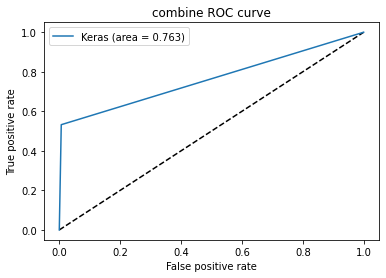

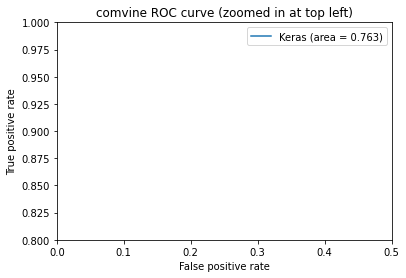

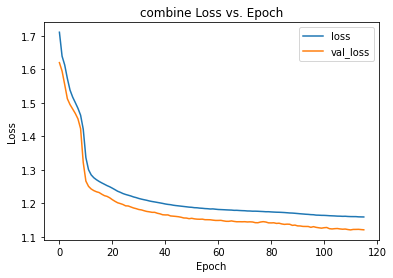

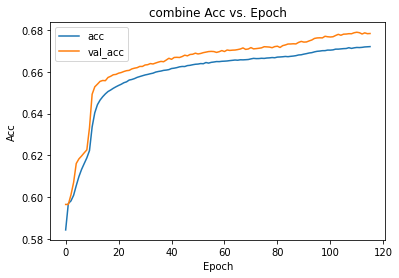

In [19]:
# ROC curve
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('combine ROC curve')
plt.legend(loc='best')
plt.savefig(fname = f'ROC_Plts/full/multi_ROC_curve_nods.png', format='png')
plt.show()

# Zoom in view of the upper left corner ROC curve
plt.figure(2)
plt.xlim(0, 0.5)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label= 'Keras (area = {:.3f})'.format(auc_keras))
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.title('comvine ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.savefig(fname = f'ROC_Plts/full/multi_ROC_curve_zoom_nods')
plt.show()

# plot loss vs epoch
plt.figure(3)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(loc="best")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('combine Loss vs. Epoch')
plt.savefig(fname = f'Epoch_Plts/full/multi_loss_epoch_nods.png', format='png')
plt.show()

# plot accuracy vs epoch
plt.figure(4)
plt.plot(history.history['sparse_categorical_accuracy'], label='acc')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='val_acc')
plt.legend(loc="best")
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.title('combine Acc vs. Epoch')
plt.savefig(fname = f'Epoch_Plts/full/multi_acc_epoch_nods.png', format='png')
plt.show()

In [20]:
total_weight = np.sum(full_df.loc[:, b'genweight'].values)
test_total_weight = np.sum(X_val_weight)
scale_weight = total_weight / test_total_weight

In [21]:
# Make copy of dataframe
X_full = full_df.values
X_train_full, X_val_full, y_ph_1, y_ph_2 = train_test_split(X_full, Y, test_size = 0.2, random_state=random_seed)
X_val_full_df = pd.DataFrame(X_val_full, columns = list(full_df.columns))

result_df = pd.DataFrame()
for column in list(full_df.columns):
    result_df[column] = X_val_full_df.loc[:, column].values
result_df[b'genweight_scale'] = X_val_full_df.loc[:, b'genweight'] * scale_weight
result_df[b'actual_label'] = Y_val
result_df[b'predicted_label'] = predict_lab
result_df[b'sig_prob'] = sig_prob
result_df[b'prob_ratio'] = prob_ratio

In [22]:
result_df.head()

,b'leading_photon_pt',b'subleading_photon_pt',b'diphoton_pt',b'diphoton_mass',b'leading_bjet_pt',b'subleading_bjet_pt',b'dibjet_pt',b'dibjet_mass',b'leading_bjet_pt_corr',b'subleading_bjet_pt_corr',...,b'run',b'lumi',b'event',b'label',b'label_num',b'genweight_scale',b'actual_label',b'predicted_label',b'sig_prob',b'prob_ratio'
0,112.175,30.3924,82.0571,119.094,79.8125,31.9062,107.938,148.747,71.3558,31.7972,...,1,120523,12052249,DiPhotonJetsBox,11,0.410664,11,11,0.003854,0.003869
1,71.6507,38.4216,35.7246,127.07,45.5938,29.125,16.6807,81.3361,48.2653,33.4198,...,1,57391,55094883,DiPhotonJetsBox,11,0.169199,11,11,0.000345,0.000345
2,80.4573,31.9393,81.8606,117.294,87.9375,32.9375,82.1116,145.943,87.8516,35.8002,...,1,36728,35258116,DiPhotonJetsBox,11,0.169199,11,11,0.000941,0.000942
3,47.8479,46.8273,1.75889,100.284,84.6875,83.1875,16.8428,170.206,86.4243,90.4989,...,1,46470,7295640,DiPhotonJetsBox,11,0.113697,11,11,0.000268,0.000268
4,117.6,48.3517,164.548,138.472,98.625,39.6562,103.859,124.135,105.56,42.096,...,1,301964,47408216,DiPhotonJetsBox,11,0.0568483,11,11,0.024059,0.024652


In [23]:
mc_labels = ['GluGluToHH', 'VBFToHH',
            'VHToGG', 'ttHToGG', 'VBFHToGG', 'GluGluHtoGG',
            'TTJets', 'TTGJets', 'TTGG_0Jets',
            'GJet_SmallPt', 'GJet_BigPt', 'DiPhotonJetsBox', 'DiPhotonJetsBox1B', 'DiPhotonJetsBox2B', 'QCDJets']

for i in range(len(mc_labels)-1):
    sig_df = result_df[result_df[b'actual_label'] == 0]
    samp_df = result_df[result_df[b'actual_label'] == i+1]
    bgd_weight = samp_df.loc[:, b'genweight_scale'].values
    sgl_weight = sig_df.loc[:, b'genweight_scale'].values
    bgd_sig_prob = samp_df.loc[:, b'sig_prob'].values
    sgl_sig_prob = sig_df.loc[:, b'sig_prob'].values
    bgd_prob_rat = samp_df.loc[:, b'prob_ratio'].values
    sgl_prob_rat = sig_df.loc[:, b'prob_ratio'].values
    
    plt.figure(figsize=(9,6))
    plt.hist(bgd_sig_prob, color='blue', weights= bgd_weight, histtype='step', bins = 20, label= f'{mc_labels[i+1]} background', density = True)
    plt.hist(sgl_sig_prob, color='orange', weights= sgl_weight, histtype='step', bins = 20, label= 'ggHH signal', density = True)
    plt.xlabel('Probability of being ggHH')
    plt.ylabel('Number of Events')
    plt.legend(loc = 'best')
    plt.title(f'Signal probability for {mc_labels[i+1]} background')
    plt.savefig(fname = f'Multi_Prob_Plts/sig_prob_{mc_labels[i+1]}_nods.png', format='png')
    plt.close()
    
    plt.figure(figsize=(9,6))
    plt.hist(bgd_prob_rat, color='blue', weights= bgd_weight, histtype='step', bins = 20, label= f'{mc_labels[i+1]} background', density = True)
    plt.hist(sgl_prob_rat, color='orange', weights= sgl_weight, histtype='step', bins = 20, label= 'ggHH signal', density = True)
    plt.xlabel('Probability Ratio')
    plt.ylabel('Number of Events')
    plt.legend(loc = 'best')
    plt.title(f'Probability ratio for {mc_labels[i+1]} background')
    plt.savefig(fname = f'Multi_Prob_Plts/prob_ratio_{mc_labels[i+1]}_nods.png', format='png')
    plt.close()

In [24]:
sig_df = result_df[result_df[b'actual_label'] == 0]
bgd_df = result_df[result_df[b'actual_label'] != 0]
bgd_weight = bgd_df.loc[:, b'genweight_scale'].values
sgl_weight = sig_df.loc[:, b'genweight_scale'].values
bgd_sig_prob = bgd_df.loc[:, b'sig_prob'].values
sgl_sig_prob = sig_df.loc[:, b'sig_prob'].values
bgd_prob_rat = bgd_df.loc[:, b'prob_ratio'].values
sgl_prob_rat = sig_df.loc[:, b'prob_ratio'].values

plt.figure(figsize=(9,6))
plt.hist(bgd_sig_prob, color='blue', weights= bgd_weight, histtype='step', bins = 20, label= f'combined background', density = True)
plt.hist(sgl_sig_prob, color='orange', weights= sgl_weight, histtype='step', bins = 20, label= 'ggHH signal', density = True)
plt.xlabel('Probability of being ggHH')
plt.ylabel('Number of Events')
plt.legend(loc = 'best')
plt.title(f'Signal probability for combined background')
plt.savefig(fname = f'Multi_Prob_Plts/sig_prob_combined_nods.png', format='png')
plt.close()

plt.figure(figsize=(9,6))
plt.hist(bgd_prob_rat, color='blue', weights= bgd_weight, histtype='step', bins = 20, label= f'combined background', density = True)
plt.hist(sgl_prob_rat, color='orange', weights= sgl_weight, histtype='step', bins = 20, label= 'ggHH signal', density = True)
plt.xlabel('Probability ratio')
plt.ylabel('Number of Events')
plt.legend(loc = 'best')
plt.title(f'Probability ratio for combined background')
plt.savefig(fname = f'Multi_Prob_Plts/prob_ratio_combined_nods.png', format='png')
plt.close()

In [25]:
mc_labels = ['GluGluToHH', 'VBFToHH',
            'VHToGG', 'ttHToGG', 'VBFHToGG', 'GluGluHtoGG',
            'TTJets', 'TTGJets', 'TTGG_0Jets',
            'GJet_SmallPt', 'GJet_BigPt', 'DiPhotonJetsBox', 'DiPhotonJetsBox1B', 'DiPhotonJetsBox2B', 'QCDJets']

for i in range(len(mc_labels)):
    print(mc_labels[i])
    original_yield = np.sum(dfs_ggHH[i].loc[:, b'genweight'].values)
    samp_df = result_df[result_df[b'actual_label'] == i]
    remaining_df = samp_df[samp_df[b'predicted_label']==0]
    remaining_yield = np.sum(remaining_df.loc[:, b'genweight_scale'].values)
    print(f'Original yield: {original_yield}')
    print(f'Remaining yield: {remaining_yield}')
    print('\n')

original_bkd_yield = np.sum(full_df[full_df[b'label_num'] != 0].loc[:, b'genweight'].values)
original_sig_yield = np.sum(full_df[full_df[b'label_num'] == 0].loc[:, b'genweight'].values)
original_significance = original_sig_yield / np.sqrt(original_bkd_yield + original_sig_yield)
val_bkd = result_df[result_df[b'label_num'] != 0]
val_sig = result_df[result_df[b'label_num'] == 0]
remaining_bkd_yield = np.sum(val_bkd[val_bkd[b'predicted_label'] == 0].loc[:, b'genweight_scale'].values)
remaining_sig_yield = np.sum(val_sig[val_sig[b'predicted_label'] == 0].loc[:, b'genweight_scale'].values)
remaining_significance = remaining_sig_yield / np.sqrt(remaining_bkd_yield + remaining_sig_yield)
print(f'Original Background Yield: {original_bkd_yield}')
print(f'Original Signal Yield: {original_sig_yield}')
print(f'Original Significance: {original_significance}')
print(f'Remaining Background Yield: {remaining_bkd_yield}')
print(f'Remaining Signal Yield: {remaining_sig_yield}')
print(f'Remaining Significance: {remaining_significance}')

GluGluToHH
Original yield: 2.160290479660034
Remaining yield: 1.1998147917491175


VBFToHH
Original yield: 0.04713541641831398
Remaining yield: 0.0076031571374609135


VHToGG
Original yield: 77.61676788330078
Remaining yield: 2.86287666502668


ttHToGG
Original yield: 8.006531715393066
Remaining yield: 0.6363170691995444


VBFHToGG
Original yield: 33.00462341308594
Remaining yield: 0.3962656060400103


GluGluHtoGG
Original yield: 446.37933349609375
Remaining yield: 5.915171425319025


TTJets
Original yield: 57538.75
Remaining yield: 1636.1946848417533


TTGJets
Original yield: 2033.285400390625
Remaining yield: 106.47844763296318


TTGG_0Jets
Original yield: 20.19515609741211
Remaining yield: 0.7227202803879883


GJet_SmallPt
Original yield: 1537.787841796875
Remaining yield: 0


GJet_BigPt
Original yield: 60913.47265625
Remaining yield: 85.48492255913959


DiPhotonJetsBox
Original yield: 80835.2265625
Remaining yield: 174.35528516362254


DiPhotonJetsBox1B
Original yield: 2525.9030761

In [26]:
mc_labels = ['GluGluToHH', 'VBFToHH',
            'VHToGG', 'ttHToGG', 'VBFHToGG', 'GluGluHtoGG',
            'TTJets', 'TTGJets', 'TTGG_0Jets',
            'GJet_SmallPt', 'GJet_BigPt', 'DiPhotonJetsBox', 'DiPhotonJetsBox1B', 'DiPhotonJetsBox2B', 'QCDJets']

for i in range(len(mc_labels)):
    original_mass_gg = dfs_ggHH[i].loc[:, b'diphoton_mass'].values
    original_mass_jj = dfs_ggHH[i].loc[:, b'dibjet_mass_corr'].values
    original_weight = dfs_ggHH[i].loc[:, b'genweight'].values
    samp_df = result_df[result_df[b'actual_label'] == i]
    remaining_df = samp_df[samp_df[b'predicted_label']==0]
    remaining_mass_gg = remaining_df.loc[:, b'diphoton_mass'].values
    remaining_mass_jj = remaining_df.loc[:, b'dibjet_mass_corr'].values
    remaining_weight = remaining_df.loc[:, b'genweight'].values
    
    
    bins = np.linspace(110, 140, 20)
    
    # M_gg plot
    plt.figure(figsize=(9,6))
    plt.hist(original_mass_gg, bins=bins, weights=original_weight, density=True, label = f'{mc_labels[i]} Original', color = 'blue')
    plt.hist(remaining_mass_gg, bins=bins, weights=remaining_weight, density=True, label = f'{mc_labels[i]} Remaining', color='orange', histtype='step')
    plt.xlabel('diphoton mass')
    plt.ylabel('normalized number of events')
    plt.title(f'{mc_labels[i]} Diphoton Mass Sculpting')
    plt.legend(loc='best')
    plt.savefig(fname = f'Mass_Sculpt_Plts/full/multi_gg_mass_sculpt_{mc_labels[i]}_nods')
    plt.close()
    
    # M_jj plot
    plt.figure(figsize=(9,6))
    plt.hist(original_mass_jj, bins=bins, weights=original_weight, density=True, label = f'{mc_labels[i]} Original', color= 'blue')
    plt.hist(remaining_mass_jj, bins=bins, weights=remaining_weight, density=True, label = f'{mc_labels[i]} Remaining', color = 'orange', histtype='step')
    plt.xlabel('dibjet corrected mass')
    plt.ylabel('normalized number of events')
    plt.title(f'{mc_labels[i]} Dibjet Corrected Mass Sculpting')
    plt.legend(loc='best')
    plt.savefig(fname = f'Mass_Sculpt_Plts/full/multi_jj_mass_sculpt_{mc_labels[i]}_nods')
    plt.close()

/usr/local/lib64/python3.6/site-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/usr/local/lib64/python3.6/site-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/usr/local/lib64/python3.6/site-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/usr/local/lib64/python3.6/site-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


## Model Optimization

In [ ]:
space  = [Integer(1, 5, name='n_hidden'),
          Integer(10, 128, name='first_neuron'),
          Integer(10, 128, name = 'n_neurons'),
          Real(0.01,0.9,name='dropout_rate'),
          Categorical(['relu', 'sigmoid', 'softmax']),
          Real(10**-5, 10**0, "log-uniform", name='learning_rate')
         ]

def multi_DNN(n_hidden = 1, first_neuron = 100, n_neurons = 64, dropout_rate = 0.4, activation_func = 'sigmoid', lr= 0.00002):
    model = Sequential()
    model.add(Dense(first_neuron, input_dim=len(training_vars), activation='relu'))
    model.add(Dropout(dropout_rate))
    for layer in range(n_hidden):
        model.add(Dense(n_neurons, activation = activation_func))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation = 'sigmoid'))
    opt = Adam(learning_rate = lr)
    model.compile(loss=SparseCategoricalCrossentropy(), optimizer=opt, metrics=[SparseCategoricalAccuracy()])
    return model

# @use_named_args(space)
# def objective(**X):
#     print("New configuration: {}".format(X))
#     model_tmp = multi_DNN(X['n_hidden'], X['first_neuron'], X['n_neurons'], X['dropout_rate'], X['activation_func'], X['lr'])
#     print (model_tmp)
#     model_tmp.fit(X_train, Y_train, epochs=200,batch_size=64, validation_split = 0.2, 
#            callbacks=[EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')])
    
#     train_accuracy = model_tmp.evaluate(X_train, Y_train)[1]
#     print("Training Accuracy: %.2f%%" % (train_accuracy * 100.0))
    
#     accuracy = model_tmp.evaluate(X_val, Y_val)[1]
#     print("Accuracy: %.2f%%" % (accuracy * 100.0))
    
#     return -accuracy